In [1]:
%run ./mri-sim-py/epg/epg_MRF.py

In [2]:
!export CUDA_VISIBLE_DEVICES=2

## Simulate pulse sequence

In [49]:
import matplotlib.pyplot as plt
from pathlib import Path
import sys, random
from tqdm import tqdm
from scipy import io
sys.path.insert(0,"./mri-sim-py/epg")
import epg, epg_MRF
import numpy as np
import torch

TR = 4e-3
generateSamples = True
mat = io.loadmat('./mri-sim-py/flip_angle_pattern.mat')
FAs = mat['alpha']
FAs = FAs[0:800]
angles_rad = np.squeeze(FAs)
# angles_rad = angles * np.pi / 180.
# plt.plot(angles_rad)
# plt.show()
save_root = Path(f'./MRFdata/train/')

N = 50000
S2 = np.zeros((N,len(FAs)))
T1min, T2min, T1max, T2max = 50e-3, 50e-3, 1500e-3, 1000e-3
if generateSamples:
    for i in tqdm(range(int(N))):
        T1 = T1min+(T1max-T1min)*random.random()
        T2 = T2min+(T2max-T2min)*random.random()
        Mxy, Mz, TE, TD = MRF_signal(angles_rad, TR, T1, T2)
        # plt.plot(abs(Mxy))
        # plt.show()
        TD = np.append(0,TD)
        S = np.transpose(np.abs(Mxy))
        S2[i,:] = S
        S2save = np.concatenate((S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S), axis=0)
        fname = f'{str(i)}'
        np.save(str(save_root / fname) + '.npy', S2save.astype(np.float32)) 
        # print(f'T1={T1}, T2={T2}')

100%|██████████| 50000/50000 [1:17:10<00:00, 10.80it/s]


## Building noise schedule

In [38]:
import torch
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    # return torch.linspace(start, end, timesteps)
    return start*(end/start)**torch.linspace(0,1,T)   

def geometric_sigma_schedule(T, sigma_min=0.01, sigma_max=378):
    return sigma_min*(sigma_max/sigma_min)**torch.linspace(0,1,T)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

def forward_diffusion_sample2(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sigma_t = get_index_from_list(sigmas, t, x_0.shape)
   
    # mean + variance
    return x_0.to(device) + sigma_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 500
sigma_min=0.00001
sigma_max=0.1
betas = linear_beta_schedule(timesteps=T, start=sigma_min, end=sigma_max)
sigmas = geometric_sigma_schedule(T=T, sigma_min=sigma_min, sigma_max=378)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [50]:
import datasets, sys, importlib
# importlib.reload(datasets)
from ml_collections.config_flags import config_flags
from absl import flags
sys.path.insert(0, "./configs/ve/")
import MRF_config
importlib.reload(MRF_config)
config_file = MRF_config.get_config()
train_dl, eval_dl = datasets.create_dataloader(config_file)


/mnt/vsomai/ScoreMatchingRecon/score_MRF/MRFdata/train


<Figure size 1500x1500 with 0 Axes>

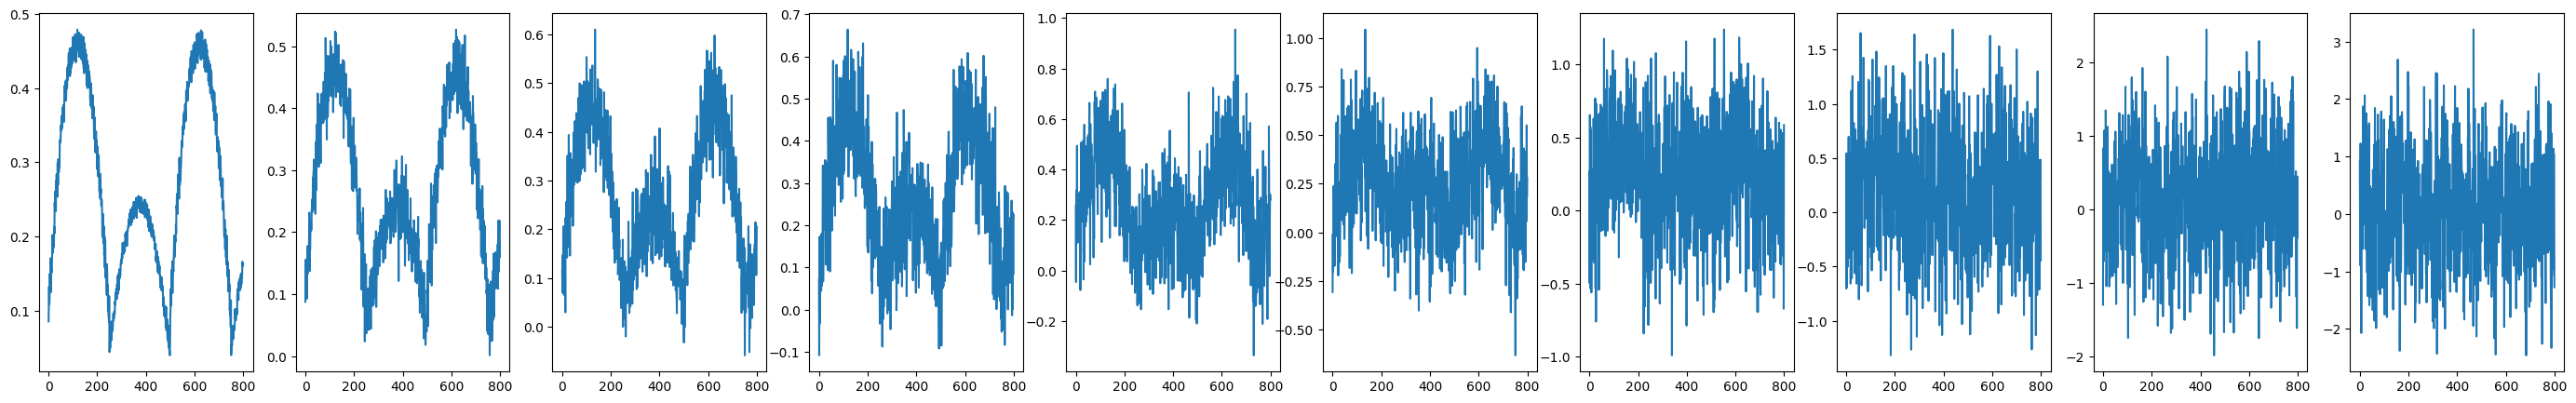

In [51]:
# Simulate forward diffusion
image = next(iter(train_dl))[0]
image = image[0,0,:]
plt.figure(figsize=(15,15))
# plt.axis('off')
# plt.plot(torch.Tensor.numpy(image[0]))
# plt.show()
num_images = 10
stepsize = int(T/num_images)
fig, (ax1) =  plt.subplots(1, int(num_images))
fig.set_size_inches(w=35, h=5)
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
   
    image_tmp, noise = forward_diffusion_sample(image,t)
    ax_tmp = ax1[int(idx/stepsize)]
    # ax_tmp.set_aspect('equal')
    ax_tmp.plot(torch.Tensor.numpy(image_tmp))
plt.show()

In [41]:
print(stepsize)

50


In [42]:
image.size()

torch.Size([800])

In [43]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [44]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 
    
@torch.no_grad()
def sample_timestep2(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    if t > 0:
        sigma_t = get_index_from_list(sigmas, t-1, x.shape)
    else:
        sigma_t = sigma_min
    sigma_tp1 = get_index_from_list(sigmas, t, x.shape)

    
    # Predictor step
    model_mean = (sigma_tp1**2-sigma_t**2) * model(x, t) + torch.sqrt(sigma_tp1**2-sigma_t**2)*torch.randn_like(x)
    
    # Corrector step
    z = torch.randn_like(x)
    eps_i = 2*0.16*torch.linalg.vector_norm(z)/torch.linalg.vector_norm(model(x, t))
    model_mean = model_mean + eps_i*model(x, t) + torch.sqrt(2*eps_i)*z
    
    return model_mean
    
@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img = torch.randn((1, 1, config_file.data.image_size, config_file.data.image_size2), device=device)
    plt.figure(figsize=(15,1.5))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            img_tmp = np.squeeze(img.detach().cpu())
            plt.plot(img_tmp[0])
    plt.show()  

class EMA(torch.nn.Module):
   def __init__(self, mu):
       super(EMA, self).__init__()
       self.mu = mu
       self.shadow = {}

   def register(self, name, val):
       self.shadow[name] = val.clone()

   def forward(self, name, x):
       assert name in self.shadow
       new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
       self.shadow[name] = new_average.clone().to(device)
       return new_average

ema = EMA(0.999)
for name, param in model.named_parameters():
   if param.requires_grad:
       ema.register(name, param.data)


In [45]:
import ScoreNetwork
importlib.reload(ScoreNetwork)
model = ScoreNetwork.SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  62437601


cuda
Epoch 0 | step 000 Loss: 0.01204568799585104 


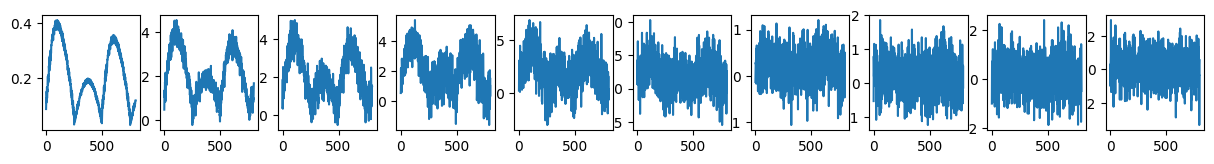

Epoch 0 | step 1000 Loss: 0.011298906989395618 


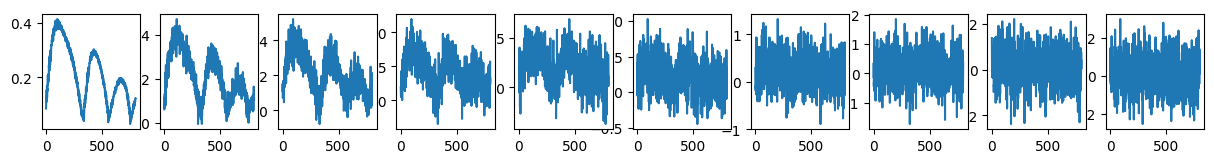

Epoch 0 | step 2000 Loss: 0.01833728328347206 


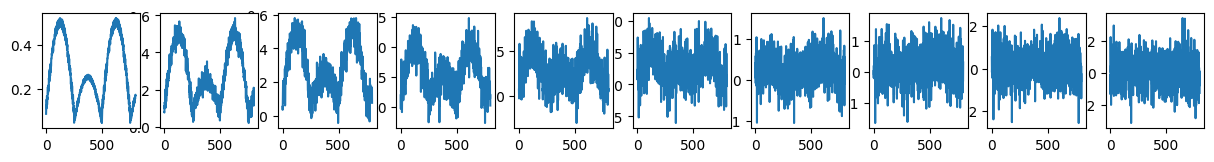

Epoch 0 | step 3000 Loss: 0.016766823828220367 


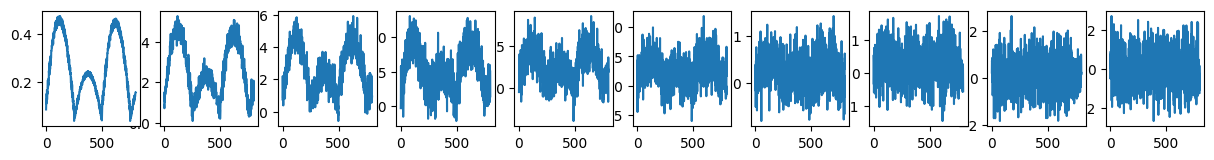

Epoch 0 | step 4000 Loss: 0.009184155613183975 


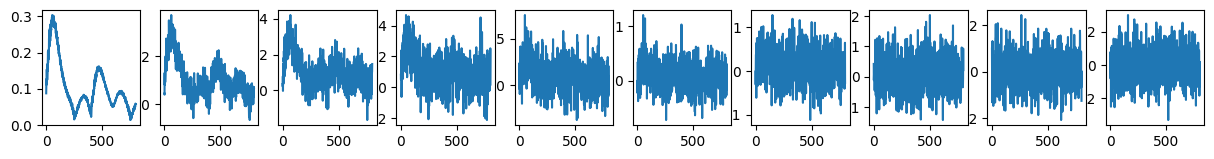

Epoch 0 | step 5000 Loss: 0.01301494613289833 


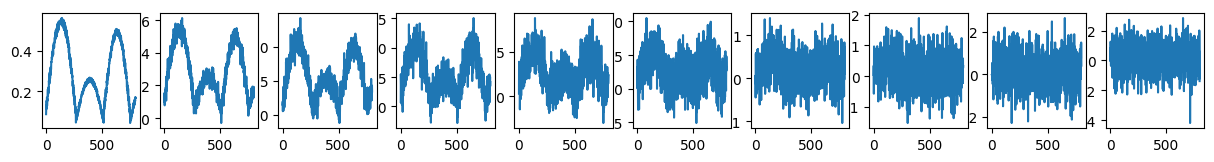

Epoch 0 | step 6000 Loss: 0.011237690225243568 


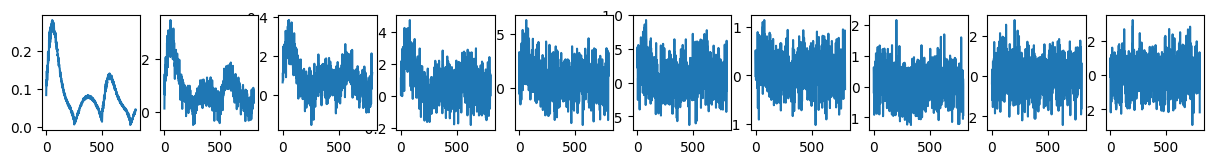

Epoch 0 | step 7000 Loss: 0.013549198396503925 


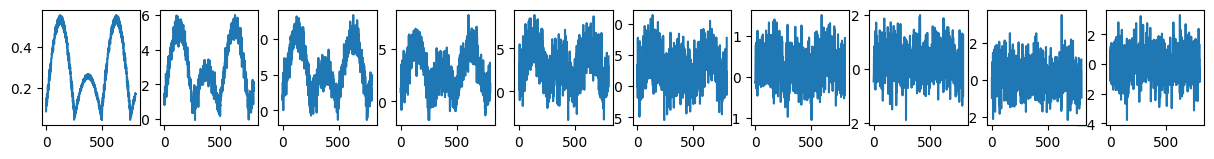

Epoch 0 | step 8000 Loss: 0.01200059149414301 


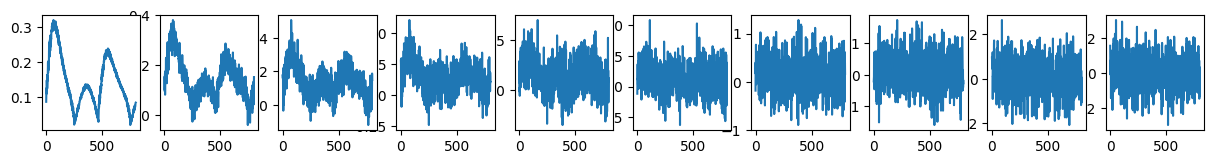

Epoch 0 | step 9000 Loss: 0.006952306255698204 


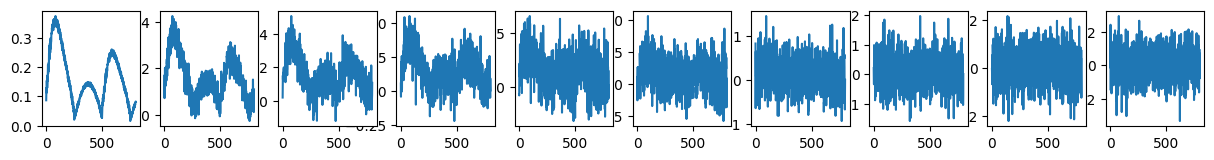

Epoch 0 | step 10000 Loss: 0.011476508341729641 


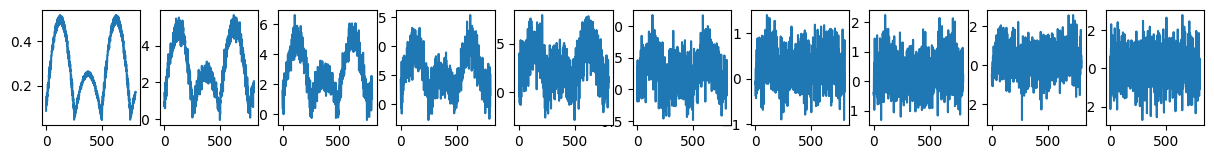

Epoch 0 | step 11000 Loss: 0.012531902641057968 


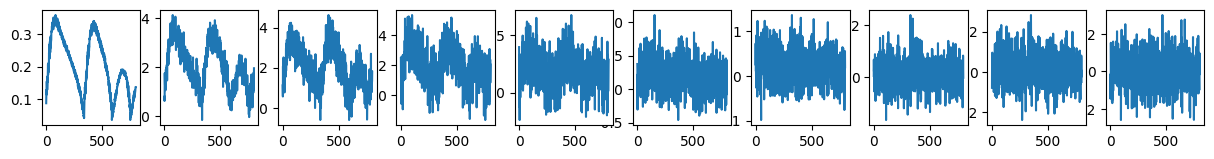

Epoch 0 | step 12000 Loss: 0.015062719583511353 


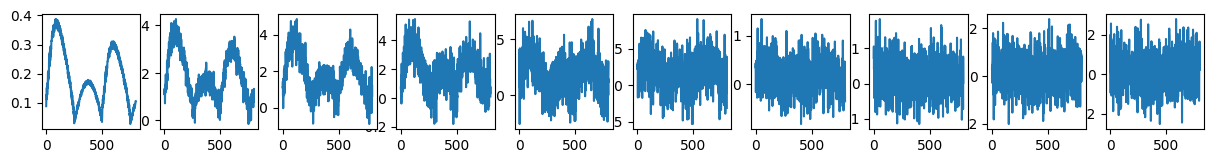

Epoch 0 | step 13000 Loss: 0.01658628135919571 


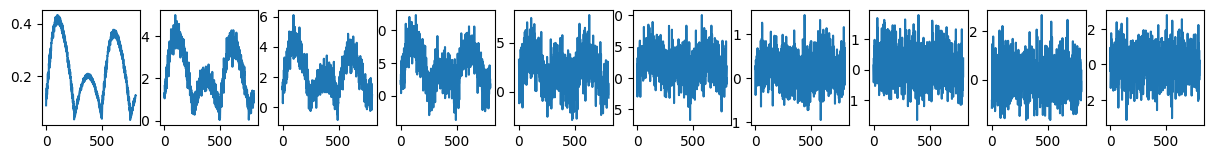

Epoch 0 | step 14000 Loss: 0.011406796984374523 


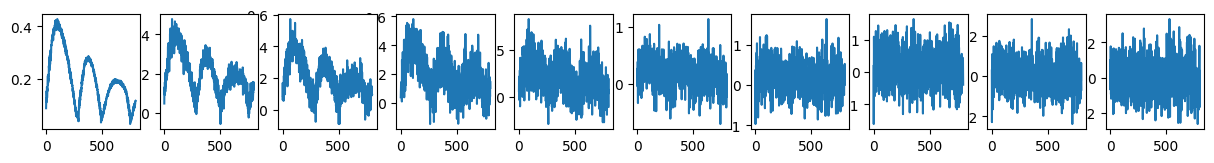

Epoch 0 | step 15000 Loss: 0.013586966320872307 


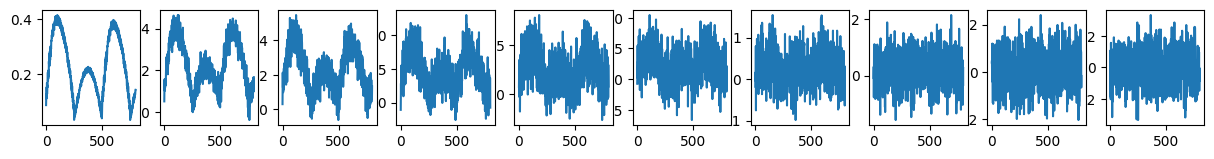

Epoch 0 | step 16000 Loss: 0.011538290418684483 


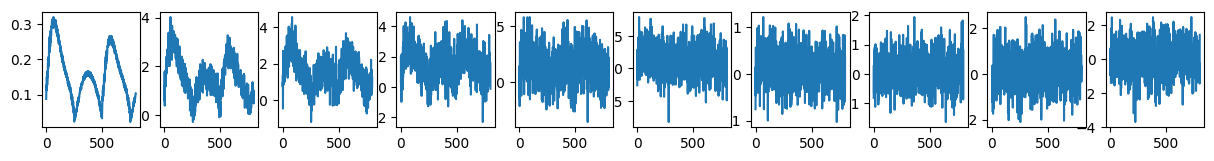

Epoch 0 | step 17000 Loss: 0.01459507830440998 


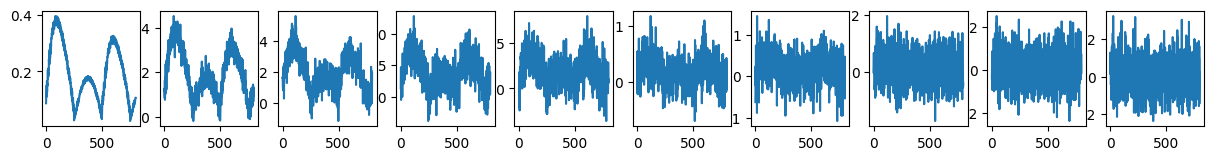

Epoch 0 | step 18000 Loss: 0.024453463032841682 


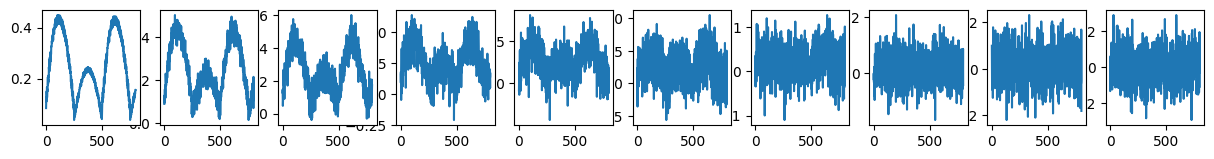

Epoch 0 | step 19000 Loss: 0.012155072763562202 


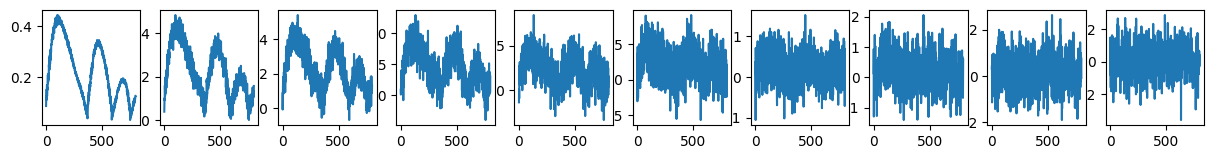

Epoch 0 | step 20000 Loss: 0.008131865411996841 


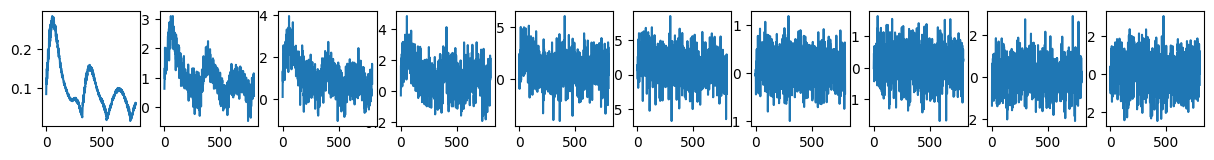

Epoch 0 | step 21000 Loss: 0.010527431964874268 


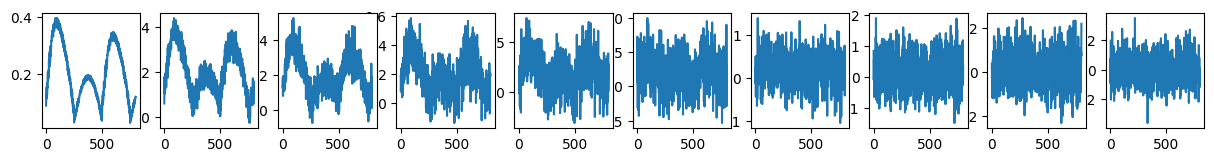

Epoch 0 | step 22000 Loss: 0.009705683216452599 


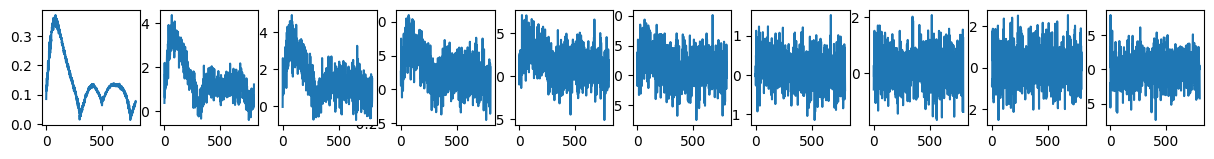

Epoch 0 | step 23000 Loss: 0.018448973074555397 


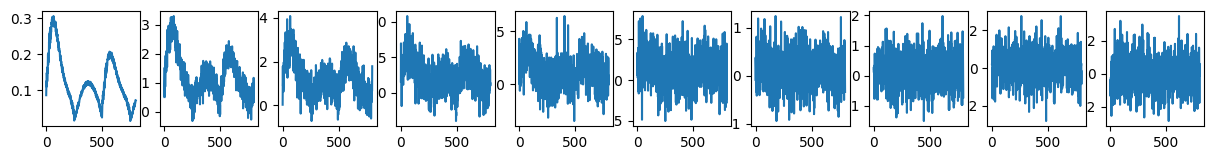

Epoch 0 | step 24000 Loss: 0.009076474234461784 


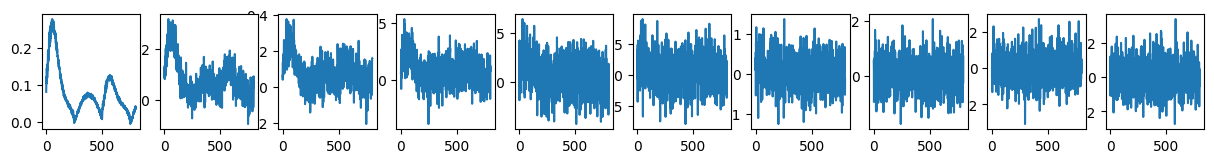

Epoch 0 | step 25000 Loss: 0.025443263351917267 


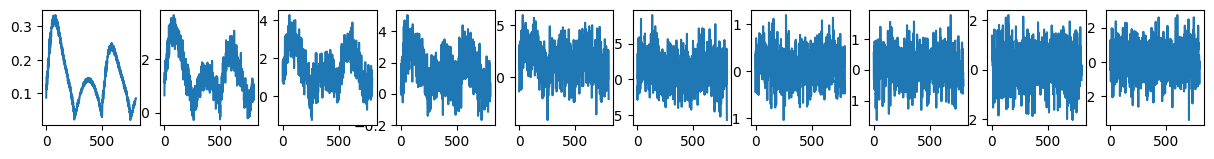

Epoch 0 | step 26000 Loss: 0.015687135979533195 


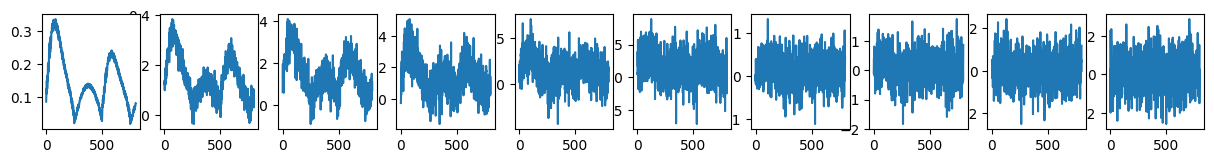

Epoch 0 | step 27000 Loss: 0.01457506138831377 


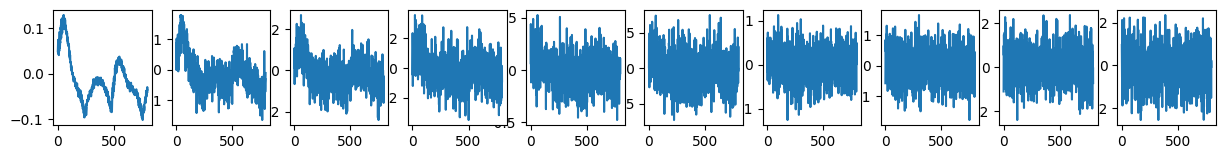

Epoch 0 | step 28000 Loss: 0.020103616639971733 


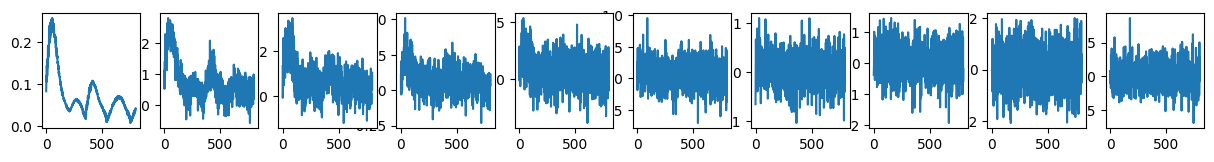

Epoch 0 | step 29000 Loss: 0.006695013493299484 


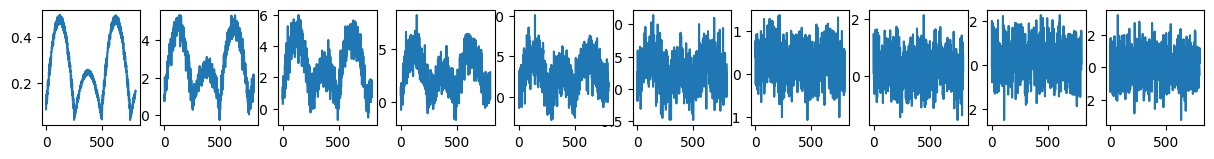

Epoch 0 | step 30000 Loss: 0.015916476026177406 


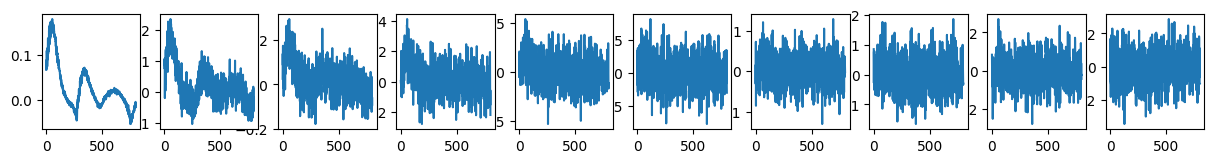

Epoch 0 | step 31000 Loss: 0.016784166917204857 


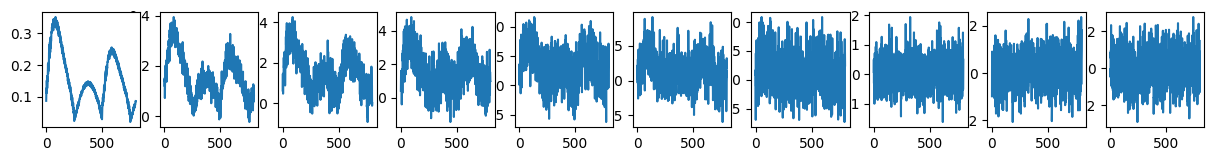

Epoch 0 | step 32000 Loss: 0.009798646904528141 


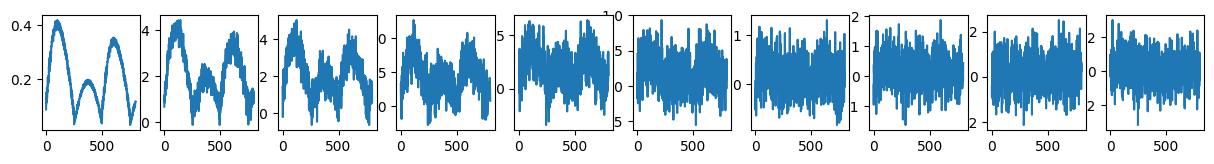

Epoch 0 | step 33000 Loss: 0.008456723764538765 


KeyboardInterrupt: 

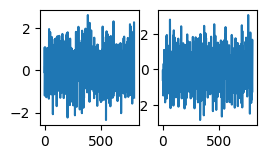

In [54]:
from torch.optim import Adam
BATCH_SIZE = config_file.training.batch_size
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.load(model,'./model')
model.to(device)
print(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 1000 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(train_dl):
      optimizer.zero_grad()
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      # t = torch.randint(0, T-1, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0][(None, )+(..., )], t)
      loss.backward()
      torch.nn.utils.clip_grad_value_(model.parameters(), 1.0)
      optimizer.step()
      for name, param in model.named_parameters():
        if param.requires_grad:
            param.data = ema(name, param.data)

      if epoch % 1 == 0 and step % 1000 == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()
        torch.save(model.state_dict(), './model_state_dict.pth')
        # buffer = io.BytesIO()
        # torch.save(model, buffer)

In [ ]:
%run ./main_fastmri.py \
 --config=configs/ve/MRF_config.py \
 --eval_folder=eval/fastmri_multicoil_knee_320 \
 --mode='train'  \
 --workdir=workdir/fastmri_multicoil_knee_320

In [ ]:
sample = np.load('./workdir/fastmri_multicoil_knee_320/samples/iter_1/sample.np')


In [ ]:
fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(np.squeeze(sample))
plt.show()